In [2]:
from foragax.base.agent_classes import *
from foragax.base.agent_methods import *
from foragax.base.space_classes import *
from foragax.base.space_methods import *
from foragax.policy.random_policy import *

In [47]:
from flax.training import orbax_utils
import orbax

import jax
import jax.numpy as jnp
from flax import struct


In [4]:
@struct.dataclass
class Animal(Agent):

    @staticmethod
    def create_agent(params: Params, unique_id: int, active_state: int, agent_type:int, key: jax.random.PRNGKey):
        key, policy_key = jax.random.split(key)
        policy = Random_Policy.create_policy(params, policy_key)
        
        agent_params_content = {'reproduction_rate': params.content['reproduction_rate'], 
                                'delta_energy': params.content['delta_energy']}
        agent_params = Params(content=agent_params_content) 
        
        space = params.content['space']
        X_pos_max = space.x_max
        Y_pos_max = space.y_max

        def create_active_agent(key, params):
            key, *pos_keys = jax.random.split(key, 4)
            X_pos = jax.random.randint(pos_keys[0], minval=0, maxval=X_pos_max-1, shape=(1,))
            Y_pos = jax.random.randint(pos_keys[1], minval=0, maxval=Y_pos_max-1, shape=(1,))
            energy = jax.random.randint(pos_keys[2], minval=1, maxval=2*params.content['delta_energy'], shape=(1,))
            #jnp.array([params.content['initial_energy']])
            state_content = {'X_pos': X_pos, 'Y_pos': Y_pos, 'energy': energy, 'reproduce': 0, 'key': key}
            state = State(content=state_content)
            return state
        
        def create_inactive_agent(key):
            state_content = {'X_pos': jnp.array([-1]), 'Y_pos': jnp.array([-1]), 'energy': jnp.array([-1]), 'reproduce': 0, 'key': key}
            state = State(content=state_content)
            return state
        
        agent_state = jax.lax.cond(active_state, lambda _: create_active_agent(key,params), lambda _: create_inactive_agent(key), None)
        return Animal(unique_id=unique_id, active_state=active_state, agent_type=agent_type, 
                    state=agent_state, policy=policy, params=agent_params, age=0.0)
    
    @staticmethod
    def step_agent(params:Params, input:Signal, animal:Agent):
        space = params.content['space']
        def step_active_agent(input, animal, space):
            energy_in = input.content['energy_in']
            X_pos = animal.state.content['X_pos']
            Y_pos = animal.state.content['Y_pos']
            energy = animal.state.content['energy']

            action, new_policy = Random_Policy.step_policy(None, animal.policy)
            action = action.content['action']
            
            # Move the animal
            X_pos_new = jax.lax.cond(action[0] < 0.25, lambda _: X_pos + 1, 
                                    lambda _: X_pos, None)
            X_pos_new = jax.lax.cond(jnp.logical_and(action[0] >= 0.25, action[0] < 0.5), lambda _: X_pos - 1, 
                                    lambda _: X_pos_new, None)
            Y_pos_new = jax.lax.cond(jnp.logical_and(action[0] >= 0.5, action[0] < 0.75), lambda _: Y_pos + 1,
                                    lambda _: Y_pos, None)
            Y_pos_new = jax.lax.cond(action[0] >= 0.75, lambda _: Y_pos - 1,
                                    lambda _: Y_pos_new, None)
            
            # check for boundaries
            X_pos_new = jax.lax.cond(jnp.logical_and(space.torous, X_pos_new[0] < space.x_min), lambda _: jnp.array([space.x_max-1]),
                                    lambda _: X_pos_new, None)
            X_pos_new = jax.lax.cond(jnp.logical_and(space.torous, X_pos_new[0] > space.x_max), lambda _: jnp.array([space.x_min]),
                                    lambda _: X_pos_new, None)
            Y_pos_new = jax.lax.cond(jnp.logical_and(space.torous, Y_pos_new[0] < space.y_min), lambda _: jnp.array([space.y_max-1]),
                                    lambda _: Y_pos_new, None)
            Y_pos_new = jax.lax.cond(jnp.logical_and(space.torous, Y_pos_new[0] > space.y_max), lambda _: jnp.array([space.y_min]),
                                    lambda _: Y_pos_new, None)
            X_pos_new = jnp.clip(X_pos_new, space.x_min, space.x_max-1)
            Y_pos_new = jnp.clip(Y_pos_new, space.y_min, space.y_max-1)
            
            energy_new = energy - 1 + animal.params.content['delta_energy']*energy_in
            
            key, head_tail_key = jax.random.split(animal.state.content['key'])
            rand_float = jax.random.uniform(head_tail_key, shape=(1,))
            reproduce = jax.lax.cond(rand_float[0] < animal.params.content['reproduction_rate'], lambda _: 1, 
                                    lambda _: animal.state.content['reproduce'], None)
            
            new_animal_state_content = {'X_pos': X_pos_new, 'Y_pos': Y_pos_new, 'energy': energy_new, 'reproduce': reproduce, 'key': key}
            new_animal_state = State(content = new_animal_state_content)
            new_animal = animal.replace(state = new_animal_state, age = animal.age + 1.0, policy=new_policy)
            return new_animal
        
        def step_inactive_agent():
            return animal

        new_animal = jax.lax.cond(animal.active_state, lambda _: step_active_agent(input, animal, space), lambda _: step_inactive_agent(), None)
        return new_animal
    
    @staticmethod
    def remove_agent(params:Params, animals:Agent, idx):
        animal_to_remove = jax.tree_util.tree_map(lambda x: x[idx], animals)
        key = animal_to_remove.state.content['key']
        state_content = {'X_pos': jnp.array([-1]), 'Y_pos': jnp.array([-1]), 'energy': jnp.array([-1]), 'reproduce': 0, 'key':key} 
        state = State(content=state_content)
        age = 0.0
        active_state = False
        removed_animal = animal_to_remove.replace(state=state, age=age, active_state=active_state)
        return removed_animal
    
    @staticmethod
    def add_agent(params:Params, animals:Agent, idx, key:jax.random.PRNGKey):
        
        copy_ids = params.content['copy_ids'] # contains the ids of the agents that are selected for reproduction
        num_active_agents = params.content['num_active_agents']

        agent_to_add = jax.tree_util.tree_map(lambda x: x[idx], animals)
        agent_to_copy = jax.tree_util.tree_map(lambda x: x[copy_ids[idx - num_active_agents]], animals)
        
        X_pos = agent_to_copy.state.content['X_pos']
        Y_pos = agent_to_copy.state.content['Y_pos']
        energy = agent_to_copy.state.content['energy']/2
        add_agent_reproduction_key = agent_to_add.state.content['key']
        state_content = {'X_pos': X_pos, 'Y_pos': Y_pos, 'energy': energy, 'reproduce': 0, 'key': add_agent_reproduction_key}
        state = State(content=state_content)
        age = 0.0
        active_state = True
        new_animal = agent_to_add.replace(state=state, age=age, active_state=active_state)
        return new_animal, key
    
    @staticmethod
    def set_agent(params:Params, animals:Agent, idx, key:jax.random.PRNGKey):
        agent_to_set = jax.tree_util.tree_map(lambda x: x[idx], animals)
        X_pos = agent_to_set.state.content['X_pos']
        Y_pos = agent_to_set.state.content['Y_pos']
        energy = agent_to_set.state.content['energy']/2
        set_agent_reproduction_key = agent_to_set.state.content['key']
        state_content = {'X_pos': X_pos, 'Y_pos': Y_pos, 'energy': energy, 'reproduce': 0, 'key': set_agent_reproduction_key}
        state = State(content=state_content)
        new_animal = agent_to_set.replace(state=state)
        return new_animal, key

In [5]:
@struct.dataclass
class Grass(Agent):
    @staticmethod
    def create_agent(params: Params, unique_id: int, active_state: int, agent_type: int, key: jax.random.PRNGKey):
        
        space = params.content['space']
        regrowth_time = params.content['regrowth_time']
        
        params_content = {'regrowth_time': regrowth_time}
        params = Params(content=params_content)

        X_pos_max = space.x_max
        
        X_pos = jnp.array([jnp.mod(unique_id, X_pos_max)])
        Y_pos = jnp.array([jnp.floor_divide(unique_id, X_pos_max)])
        
        key, count_down_key, fully_grown_key = jax.random.split(key, 3)
        head_tail = jax.random.uniform(fully_grown_key, shape=(1,))
        fully_grown = jax.lax.cond(head_tail[0] < 0.5, lambda _: False, lambda _: True, None)
        count_down = jax.lax.cond(fully_grown, lambda _: jnp.array([0]), lambda _: jax.random.randint(count_down_key, minval=1, maxval=regrowth_time, shape=(1,)), None)

        state_content = {'X_pos': X_pos, 'Y_pos': Y_pos, 'fully_grown': fully_grown, 'count_down': count_down}
        state = State(content=state_content)
        age = 0.0
        return Grass(unique_id=unique_id, active_state=active_state, 
                     agent_type=agent_type, state=state, age=age, 
                     params=params, policy=None)
    
    @staticmethod
    def step_agent(params:Params, input:Signal, grass:Agent):
        energy_out = input.content['energy_out'] # the logic of fully grown grass gets eaten is in the main step function
        count_down = grass.state.content['count_down']
        fully_grown = grass.state.content['fully_grown']
        
        new_count_down, new_fully_grown = jax.lax.cond(energy_out[0], lambda _: (jnp.array([grass.params.content['regrowth_time']]), False), 
                                                       lambda _: (count_down, fully_grown), None)
        new_count_down = jax.lax.cond(new_fully_grown, lambda _: new_count_down, lambda _: new_count_down - 1, None)
        new_fully_grown = jax.lax.cond(new_count_down[0] <= 0, lambda _: True, lambda _: new_fully_grown, None)

        new_grass_state_content = {'X_pos': grass.state.content['X_pos'], 'Y_pos': grass.state.content['Y_pos'], 
                                   'fully_grown': new_fully_grown, 'count_down': new_count_down}
        
        new_grass_state = State(content=new_grass_state_content)

        new_grass = grass.replace(state=new_grass_state)
        return new_grass
        
        

In [6]:
space = create_space(x_min=0, x_max=10, y_min=0, y_max=10, torous=True, wall_array = None)

In [7]:
def interaction(wolves:Animal, sheeps:Animal, grasses:Grass):
    
    # wolves eat sheep:
    def one_wolf_all_sheep(wolf, sheeps): # vmap across all wolves

        def one_wolf_one_sheep(wolf, sheep): # vmap across all sheep
            wolf_X_pos = wolf.state.content['X_pos']
            wolf_Y_pos = wolf.state.content['Y_pos']
            sheep_X_pos = sheep.state.content['X_pos']
            sheep_Y_pos = sheep.state.content['Y_pos']
            condition = jnp.logical_and(wolf_X_pos[0] == sheep_X_pos[0], wolf_Y_pos[0] == sheep_Y_pos[0])
            
            wolf_energy_in = jax.lax.cond(condition, lambda _: jnp.array([1.0]), lambda _: jnp.array([0.0]), None)
            return wolf_energy_in
        
        one_wolf_energy_from_all_sheeps = jax.vmap(one_wolf_one_sheep, in_axes=(None, 0))(wolf, sheeps)
        return one_wolf_energy_from_all_sheeps
    
    wolves_sheeps_matrix = jax.vmap(one_wolf_all_sheep, in_axes=(0, None))(wolves, sheeps)
    '''
    for wolves this matrix is summed across all columns to get the total energy gained by each wolf
    for sheeps we take the max of the matrix across all rows to get if the sheep is eaten or not
    '''
    wolves_energy_in = jnp.sum(wolves_sheeps_matrix, axis=1, dtype=jnp.int32)
    sheeps_eaten = jnp.max(wolves_sheeps_matrix, axis=0)

    # sheeps eat grass:
    def one_sheep_all_grass(sheep, grasses): # vmap across all sheeps

        def one_sheep_one_grass(sheep, grass): # vmap across all grass
            sheep_X_pos = sheep.state.content['X_pos']
            sheep_Y_pos = sheep.state.content['Y_pos']
            grass_X_pos = grass.state.content['X_pos']
            grass_Y_pos = grass.state.content['Y_pos']
            grass_fully_grown = grass.state.content['fully_grown']
            condition = jnp.logical_and(sheep_X_pos[0] == grass_X_pos[0], sheep_Y_pos[0] == grass_Y_pos[0])
            condition = jnp.logical_and(condition, grass_fully_grown)

            sheep_energy_in = jax.lax.cond(condition, lambda _: jnp.array([1.0]), lambda _: jnp.array([0.0]), None)
            return sheep_energy_in
        one_sheep_energy_from_all_grass = jax.vmap(one_sheep_one_grass, in_axes=(None, 0))(sheep, grasses)
        return one_sheep_energy_from_all_grass
    
    sheeps_grass_matrix = jax.vmap(one_sheep_all_grass, in_axes=(0, None))(sheeps, grasses)
    '''
    for sheeps this matrix is summed across all columns to get the total energy gained by each sheep
    for grass we take the max of the matrix across all rows to get if the grass is eaten or not
    '''
    sheeps_energy_in = jnp.sum(sheeps_grass_matrix, axis=1, dtype=jnp.int32)
    grasses_eaten = jnp.max(sheeps_grass_matrix, axis=0)

    return wolves_energy_in, sheeps_energy_in, sheeps_eaten, grasses_eaten
jit_interaction = jax.jit(interaction)

        


In [44]:
@struct.dataclass
class Rec_Data:
    grass_xs: jnp.ndarray
    grass_ys: jnp.ndarray
    grass_count_downs: jnp.ndarray

    sheep_xs: jnp.ndarray
    sheep_ys: jnp.ndarray
    sheep_energies: jnp.ndarray
    sheep_active_states: jnp.ndarray

    wolf_xs: jnp.ndarray
    wolf_ys: jnp.ndarray
    wolf_energies: jnp.ndarray
    wolf_active_states: jnp.ndarray

def init_rec_data(frames:jnp.int32, grasses:Agent_Set, sheeps:Agent_Set, wolves:Agent_Set):
    grass_xs = jnp.zeros((frames, grasses.num_total_agents, 1))
    grass_ys = jnp.zeros((frames, grasses.num_total_agents, 1))
    grass_count_downs = jnp.zeros((frames, grasses.num_total_agents, 1))
    
    sheep_xs = jnp.zeros((frames, sheeps.num_total_agents, 1))
    sheep_ys = jnp.zeros((frames, sheeps.num_total_agents, 1))
    sheep_energies = jnp.zeros((frames, sheeps.num_total_agents, 1))
    sheep_active_states = jnp.zeros((frames, sheeps.num_total_agents))

    wolf_xs = jnp.zeros((frames, wolves.num_total_agents, 1))
    wolf_ys = jnp.zeros((frames, wolves.num_total_agents, 1))
    wolf_energies = jnp.zeros((frames, wolves.num_total_agents, 1))
    wolf_active_states = jnp.zeros((frames, wolves.num_total_agents))

    rec_data_obj = Rec_Data(grass_xs=grass_xs, grass_ys=grass_ys, grass_count_downs=grass_count_downs,
                                    sheep_xs=sheep_xs, sheep_ys=sheep_ys, sheep_energies=sheep_energies, sheep_active_states=sheep_active_states,
                                    wolf_xs=wolf_xs, wolf_ys=wolf_ys, wolf_energies=wolf_energies, wolf_active_states=wolf_active_states)
    return rec_data_obj

def record_data(grasses, sheeps, wolves, rec_data_obj, frame):
    grasses_xs = rec_data_obj.grass_xs.at[frame].set(grasses.state.content['X_pos'])
    grasses_ys = rec_data_obj.grass_ys.at[frame].set(grasses.state.content['Y_pos'])
    grasses_count_downs = rec_data_obj.grass_count_downs.at[frame].set(grasses.state.content['count_down'])

    sheeps_xs = rec_data_obj.sheep_xs.at[frame].set(sheeps.state.content['X_pos'])
    sheeps_ys = rec_data_obj.sheep_ys.at[frame].set(sheeps.state.content['Y_pos'])
    sheeps_energies = rec_data_obj.sheep_energies.at[frame].set(sheeps.state.content['energy'])
    sheeps_active_states = rec_data_obj.sheep_active_states.at[frame].set(sheeps.active_state)

    wolves_xs = rec_data_obj.wolf_xs.at[frame].set(wolves.state.content['X_pos'])
    wolves_ys = rec_data_obj.wolf_ys.at[frame].set(wolves.state.content['Y_pos'])
    wolves_energies = rec_data_obj.wolf_energies.at[frame].set(wolves.state.content['energy'])
    wolves_active_states = rec_data_obj.wolf_active_states.at[frame].set(wolves.active_state)

    rec_data_obj = rec_data_obj.replace(grass_xs=grasses_xs, grass_ys=grasses_ys, grass_count_downs=grasses_count_downs,
                                                sheep_xs=sheeps_xs, sheep_ys=sheeps_ys, sheep_energies=sheeps_energies, sheep_active_states=sheeps_active_states,
                                                wolf_xs=wolves_xs, wolf_ys=wolves_ys, wolf_energies=wolves_energies, wolf_active_states=wolves_active_states)
    return rec_data_obj
jit_record_data = jax.jit(record_data)

In [69]:
class Ecosystem():
    grasses: Agent_Set
    sheeps: Agent_Set
    wolves: Agent_Set
    space: Space
    sim_steps: jnp.int32
    render_data: Render_Data
    num_render_frames: jnp.int32
    
    key: jax.random.PRNGKey
    
    def __init__(self, grass_regrowth_time, wolf_reproduction_rate, wolf_energy, init_wolves,     
                 sheep_reproduction_rate, sheep_energy, init_sheeps,
                 X_max, Y_max, sim_steps, num_render_frames, key):
        self.key = key
        self.sim_steps = sim_steps

        self.space = create_space(x_min=0, x_max=X_max, y_min=0, y_max=Y_max, torous=True, wall_array = None)
        
        key, grass_key = jax.random.split(key)
        grass_num = self.space.x_max*self.space.y_max
        self.grasses = Agent_Set(agent=Grass, num_total_agents=grass_num, num_active_agents=grass_num, agent_type=0)
        grass_params_content = {'regrowth_time': grass_regrowth_time, 'space': self.space}
        grass_params = Params(content=grass_params_content)
        self.grasses.agents = create_agents(params=grass_params, agent_set=self.grasses, key=grass_key)

        key, sheep_key = jax.random.split(key)
        self.sheeps = Agent_Set(agent=Animal, num_total_agents = 300, num_active_agents = init_sheeps, agent_type=1)
        sheep_params_content = {'reproduction_rate': sheep_reproduction_rate, 'delta_energy': sheep_energy, 'space': self.space}
        sheep_params = Params(content=sheep_params_content)
        self.sheeps.agents = create_agents(params=sheep_params, agent_set=self.sheeps, key=sheep_key)

        key, wolf_key = jax.random.split(key)
        self.wolves = Agent_Set(agent=Animal, num_total_agents = 300, num_active_agents = init_wolves, agent_type=2)
        wolf_params_content = {'reproduction_rate': wolf_reproduction_rate, 'delta_energy': wolf_energy, 'space': self.space}
        wolf_params = Params(content=wolf_params_content)
        self.wolves.agents = create_agents(params=wolf_params, agent_set=self.wolves, key=wolf_key)
        
        self.num_render_frames = num_render_frames
        self.rec_data = init_rec_data(num_render_frames, self.grasses, self.sheeps, self.wolves)

        self.orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
        rec_data_dict = {'rec_data': self.rec_data}
        self.save_args = orbax_utils.save_args_from_target(rec_data_dict)
        options = orbax.checkpoint.CheckpointManagerOptions(max_to_keep=100, create=True)
        self.checkpoint_manager = orbax.checkpoint.CheckpointManager('./rec_data', self.orbax_checkpointer, options)



    @staticmethod
    def select_dead_sheeps(sheeps_agents:Agent, select_params:Params):
        energy = jnp.reshape(sheeps_agents.state.content['energy'], (-1))
        is_eaten = jnp.reshape(select_params.content['sheeps_eaten'], (-1))
        is_dead = jnp.logical_or(energy <= 0, is_eaten)
        is_dead = jnp.logical_and(is_dead, sheeps_agents.active_state)
        return is_dead
    
    @staticmethod
    def select_dead_wolves(wolves_agents:Agent, select_params:Params):
        energy = jnp.reshape(wolves_agents.state.content['energy'], (-1))
        is_dead = jnp.logical_and(energy <= 0, wolves_agents.active_state)
        return is_dead
    
    @staticmethod
    def select_reproduce_animals(animals_agents:Agent, select_params:Params):
        is_reproduce = jnp.reshape(animals_agents.state.content['reproduce'], (-1))
        return jnp.logical_and(is_reproduce, animals_agents.active_state)
    
    @staticmethod
    def get_num_animals_to_add(num_selected, active_state_arr, max_num):
        num_active = jnp.sum(active_state_arr, dtype=jnp.int32)
        num_to_add = max_num - num_active
        num_to_add = jax.lax.cond(num_to_add > num_selected, lambda _: num_selected, lambda _: num_to_add, None)
        return num_to_add, num_active
    
    @staticmethod
    def add_animals(animal_agents, max_num, key):
        # select the animals that are going to reproduce
        num_animal_reproduce, animal_reproduce_indx = jit_select_agents(Ecosystem.select_reproduce_animals, None, animal_agents)
        num_animal_reproduce, num_active_animals = jax.jit(Ecosystem.get_num_animals_to_add)(num_animal_reproduce, animal_agents.active_state, max_num)

        # add the animals that are going to reproduce
        animal_add_params_content = {'copy_ids': animal_reproduce_indx, 'num_active_agents': num_active_animals}
        animal_add_params = Params(content=animal_add_params_content)
        new_animal_agents, key = jit_add_agents(Animal.add_agent, num_agents_add=num_animal_reproduce, 
                                                add_params=animal_add_params, agents=animal_agents, key=key)
        
        # set the energy of the animals that are going to reproduce to half and remove the reproduce flag
        animal_set_params_content = {'set_ids': animal_reproduce_indx}
        animal_set_params = Params(content=animal_set_params_content)
        new_animal_agents, key = jit_set_agents(Animal.set_agent, num_agents_set=num_animal_reproduce, 
                                                set_params=animal_set_params, agents=new_animal_agents, key=key)
        
        # sort the animals in descending order of reproduction so that in the next step the animals that were slected but did not reproduce are at beginning
        new_animal_agents, sorted_ids = jit_sort_agents(quantity=new_animal_agents.state.content['reproduce'], ascend=False, agents=new_animal_agents)
        
        return new_animal_agents, num_active_animals,key

    
    
    def step(self):
        # interaction
        wolves_energy_in, sheeps_energy_in, sheeps_eaten, grasses_eaten = jit_interaction(self.wolves.agents, self.sheeps.agents, self.grasses.agents)
        
        # agent steps movement and energy update
        grass_step_signal = Signal(content={'energy_out': grasses_eaten})
        self.grasses.agents = step_agents(params=None, agent_set=self.grasses, input=grass_step_signal)


        animals_step_param_content = {'space': self.space}
        animals_step_params = Params(content=animals_step_param_content)

        sheep_step_signal = Signal(content={'energy_in': sheeps_energy_in})
        self.sheeps.agents = step_agents(params=animals_step_params, agent_set=self.sheeps, input=sheep_step_signal)

        wolf_step_signal = Signal(content={'energy_in': wolves_energy_in})
        self.wolves.agents = step_agents(params=animals_step_params, agent_set=self.wolves, input=wolf_step_signal)

        # remove eaten or energy defficient sheeps
        
        # select the dead sheeps
        dead_sheep_select_params_content = {'sheeps_eaten': sheeps_eaten}   
        dead_sheep_select_params = Params(content=dead_sheep_select_params_content)
        num_sheeps_dead, sheep_remove_indx = jit_select_agents(Ecosystem.select_dead_sheeps, dead_sheep_select_params, self.sheeps.agents)
        
        # remove the dead sheeps
        dead_sheep_remove_params_content = {'remove_ids': sheep_remove_indx}
        dead_sheep_remove_params = Params(content=dead_sheep_remove_params_content)
        self.sheeps.agents = jit_remove_agents(Animal.remove_agent, num_agents_remove=num_sheeps_dead, 
                                               remove_params=dead_sheep_remove_params, agents=self.sheeps.agents)

        #sort the sheeps in descending order of activation so that the inactive sheeps are at the end
        self.sheeps.agents, sorted_ids = jit_sort_agents( quantity=self.sheeps.agents.active_state, ascend=False, agents=self.sheeps.agents)
        
        
        # remove dead wolves

        # select the dead wolves
        num_wolves_dead, wolf_remove_indx = jit_select_agents(Ecosystem.select_dead_wolves, None, self.wolves.agents)
        # remove the dead wolves
        dead_wolf_remove_params_content = {'remove_ids': wolf_remove_indx}
        dead_wolf_remove_params = Params(content=dead_wolf_remove_params_content)
        self.wolves.agents = jit_remove_agents(Animal.remove_agent, num_agents_remove=num_wolves_dead, 
                                               remove_params=dead_wolf_remove_params, agents=self.wolves.agents)
        
        #sort the wolves in descending order of activation so that the inactive wolves are at the end
        self.wolves.agents, sorted_ids = jit_sort_agents( quantity=self.wolves.agents.active_state, ascend=False, agents=self.wolves.agents)
        
        # add new sheeps and wolves
        self.sheeps.agents, num_active_sheeps, self.key = jax.jit(Ecosystem.add_animals)(self.sheeps.agents, self.sheeps.num_total_agents, self.key)
        self.wolves.agents, num_active_wolves, self.key = jax.jit(Ecosystem.add_animals)(self.wolves.agents, self.wolves.num_total_agents, self.key)

        return num_active_sheeps, num_active_wolves
    
    def run(self, rec_start_frame):
        sim_step = 0
        record_flag = False
        record_frame = 0
        num_wolf = []
        num_sheep = []
        while sim_step < self.sim_steps:
            num_active_sheeps, num_active_wolves = self.step()
            num_wolf.append(num_active_wolves)
            num_sheep.append(num_active_sheeps)
            sim_step += 1
            
            if sim_step == rec_start_frame:
                record_flag = True
                self.rec_data = init_rec_data(self.num_render_frames, self.grasses, self.sheeps, self.wolves)
            if record_flag:
                self.rec_data = jit_record_data(self.grasses.agents, self.sheeps.agents, self.wolves.agents, self.rec_data, record_frame)
                record_frame += 1
                if record_frame == self.num_render_frames:
                    rec_data = {'rec_data': self.rec_data}
                    self.checkpoint_manager.save(sim_step, rec_data, save_kwargs={'save_args': self.save_args})
                    record_flag = False
        return num_sheep, num_wolf    

In [95]:
num_recording_frames = 100
rec_start_frame = 50
eco = Ecosystem(grass_regrowth_time=30, wolf_reproduction_rate=0.08, wolf_energy=30, init_wolves=50, 
                sheep_reproduction_rate=0.2, sheep_energy=5, init_sheeps=100, 
                X_max=25, Y_max=25, sim_steps=1000, num_render_frames=num_recording_frames, key=jax.random.PRNGKey(0))
num_active_sheeps, num_active_wolves = eco.run(rec_start_frame=rec_start_frame)


AgentSet initialized
AgentSet initialized
AgentSet initialized


In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
palette = "viridis"
sns.set_palette(palette)
from matplotlib import animation

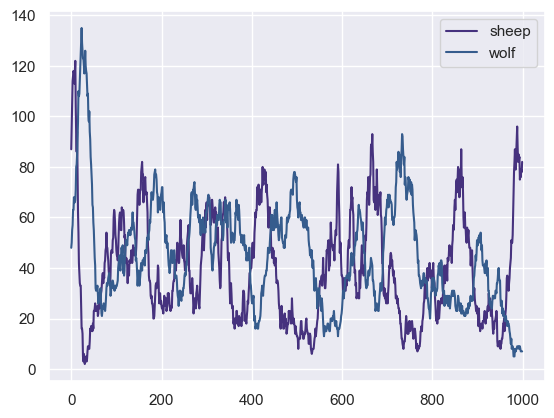

In [97]:
plt.plot(num_active_sheeps, label='sheep')
plt.plot(num_active_wolves, label='wolf')
plt.legend()
plt.show()

In [98]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
restored_data = orbax_checkpointer.restore('./rec_data/'+str(num_recording_frames+rec_start_frame-1)+'/default')
rec_data = restored_data['rec_data']


In [100]:
def render(rec_data):
    fig, ax = plt.subplots(figsize=(10,10))
    
    grass_xs = rec_data['grass_xs'][0]
    grass_ys = rec_data['grass_ys'][0]
    grass_counters = rec_data['grass_count_downs'][0]
    grass_render = ax.scatter(grass_xs, grass_ys, c='green', s=100, label='grass',marker=',', alpha= jnp.clip(1.0 - (grass_counters/30.0), 0.0, 1.0))

    sheep_xs = rec_data['sheep_xs'][0]
    sheep_ys = rec_data['sheep_ys'][0]
    sheep_render = ax.scatter(sheep_xs, sheep_ys, c='blue', s=100, label='sheep')

    wolf_xs = rec_data['wolf_xs'][0]
    wolf_ys = rec_data['wolf_ys'][0]
    wolf_render = ax.scatter(wolf_xs, wolf_ys, c='red', s=100, label='wolf', marker='x')
    plt.legend()

    def render_update(step):
        grass_xs = rec_data['grass_xs'][step]
        grass_ys = rec_data['grass_ys'][step]
        grass_counters = rec_data['grass_count_downs'][step]
        grass_render.set_offsets(jnp.column_stack([grass_xs, grass_ys]))
        grass_render.set_alpha(jnp.clip(1.0 - (grass_counters/30.0), 0.0, 1.0))

        sheep_xs = rec_data['sheep_xs'][step]
        sheep_ys = rec_data['sheep_ys'][step]
        sheep_render.set_offsets(jnp.column_stack([sheep_xs, sheep_ys]))

        wolf_xs = rec_data['wolf_xs'][step]
        wolf_ys = rec_data['wolf_ys'][step]
        wolf_render.set_offsets(jnp.column_stack([wolf_xs, wolf_ys]))
        return grass_render, sheep_render, wolf_render
    
    ani = animation.FuncAnimation(fig, render_update, frames=len(rec_data['sheep_xs']), interval=100, blit=True)
    ani.save('./video/sim.mp4', writer='ffmpeg', fps=10)
    plt.close()
render(rec_data)